<a href="https://colab.research.google.com/github/xli2522/simple-BBH-waveform/blob/main/simple_BBH_waveform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
# -- Uncomment following line if running in Google Colab
! pip install -q 'lalsuite==6.82' 'PyCBC==1.18.0'

     |████████████████████████████████| 27.3 MB 50.3 MB/s 
     |████████████████████████████████| 6.3 MB 34.9 MB/s 


In [30]:
%matplotlib inline
import pylab
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

import numpy as np
import scipy
import scipy.signal
import matplotlib.pyplot as plt


##1. Merger Frequency Ranges of BBH Systems

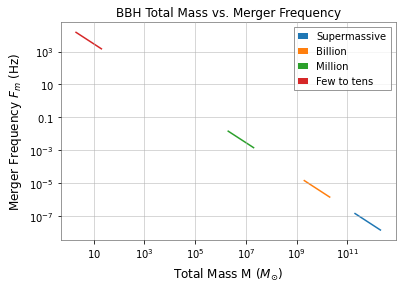

[[1.4604595344127507e-07, 1.460459534412751e-08], [1.4604595344127508e-05, 1.4604595344127509e-06], [0.014604595344127507, 0.001460459534412751], [14604.595344127509, 1460.4595344127508]]


In [31]:
# Frequency ranges of BBH mergers
def fmerger(M):
    '''Calculates the merger freuqency of a BBH system given the total mass M of the system

    '''
    c = 3*10**8
    G = 6.674*10**(-11)
    R = 1.7
    freq = (2*c**3)/(R**(3/2)*G*M*1.989*10**30)/(2*np.pi)

    return freq

# Calculate the frequency ranges of 
ranges = []; masses = []
# 1. Supermassive 10**11 Msolar
Mmin = 2*10**11; Mmax = 2*10**12
ranges.append([fmerger(Mmin), fmerger(Mmax)])
masses.append([Mmin, Mmax])
# 2. Billion Msolar
Mmin = 2*10**9; Mmax = 2*10**10
ranges.append([fmerger(Mmin), fmerger(Mmax)])
masses.append([Mmin, Mmax])
# 3. Million Msolar
Mmin = 2*10**6; Mmax = 2*10**7
ranges.append([fmerger(Mmin), fmerger(Mmax)])
masses.append([Mmin, Mmax])
# 4. Few to tens Msolar
Mmin = 2; Mmax = 20
ranges.append([fmerger(Mmin), fmerger(Mmax)])
masses.append([Mmin, Mmax])

for i in range(len(ranges)):
    plt.plot(masses[i], ranges[i])
plt.legend(['Supermassive', 'Billion','Million', 'Few to tens'])
plt.title('BBH Total Mass vs. Merger Frequency')
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r'Total Mass M ($M_{\odot}$)')
plt.ylabel(r'Merger Frequency $F_m$ (Hz)')
plt.show()

print(ranges)

##2. Individual Mass Estimation of GW150914

###2.1 Obtain GW150914 Data from LIGO Database

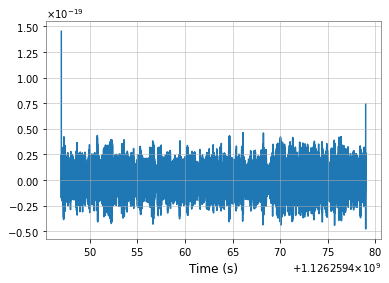

In [33]:
merger = Merger("GW150914")

# Get the data from H and L detectors
hdata = merger.strain('H1')
ldata = merger.strain('L1')

# Remove the low frequency content and downsample the data to 2048Hz
hdata = highpass(hdata, 15.0)
hdata = resample_to_delta_t(hdata, 1.0/2048)

ldata = highpass(ldata, 15.0)
ldata = resample_to_delta_t(ldata, 1.0/2048)

pylab.plot(hdata.sample_times, hdata)
#pylab.plot(ldata.sample_times, ldata)
pylab.xlabel('Time (s)')
pylab.show()

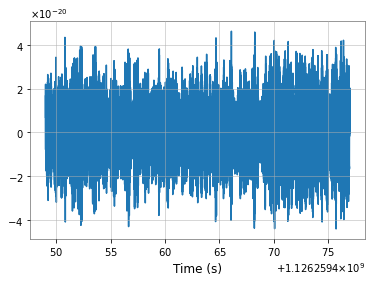

In [34]:
conditionedhdata = hdata.crop(2, 2)

pylab.plot(conditionedhdata.sample_times, conditionedhdata)
pylab.xlabel('Time (s)')
pylab.show()

In [36]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimate the power spectral density

# We use 4 second samples of our time series in Welch method.
psd = conditionedhdata.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner
psd = interpolate(psd, conditionedhdata.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to inform the function to not include frequencies
# below this frequency. 
psd = inverse_spectrum_truncation(psd, 4 * conditionedhdata.sample_rate,
                                  low_frequency_cutoff=15)

Text(0, 0.5, 'Strain')

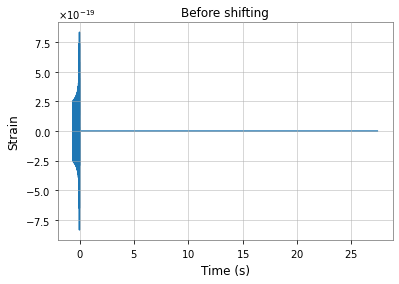

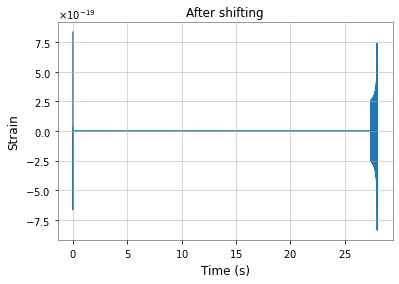

In [38]:
from pycbc.waveform import get_td_waveform
# In this case we "know" what the signal parameters are. In a search
# we would grid over the parameters and calculate the SNR time series
# for each one

# We'll assume equal masses, and non-rotating black holes which is within the posterior probability
# of GW150914. 
m = 36 # Solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditionedhdata.delta_t,
                     f_lower=20)

# We will resize the vector to match our data
hp.resize(len(conditionedhdata))

# By convention waveforms returned from `get_td_waveform` have their
# merger stamped with time zero, so we can use the start time to 
# shift the merger into position
pylab.figure()
pylab.title('Before shifting')
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

template = hp.cyclic_time_shift(hp.start_time)

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

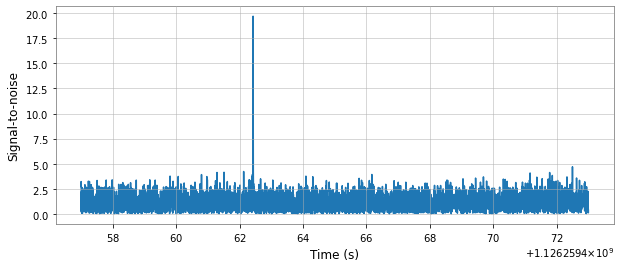

We found a signal at 1126259462.4248047s with SNR 19.677089013145903


In [56]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditionedhdata,
                     psd=psd, low_frequency_cutoff=20)

snr = snr.crop(4 + 4, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

In [57]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time - conditionedhdata.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditionedhdata.start_time

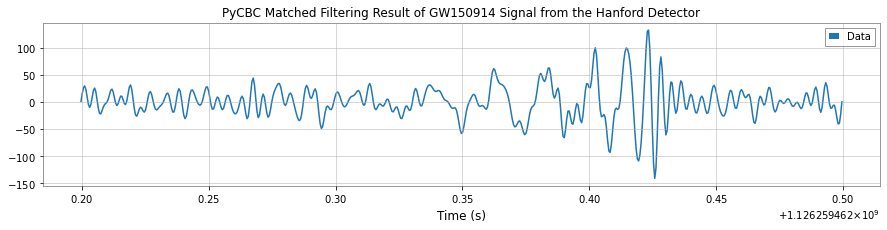

In [59]:
# We do it this way so that we can whiten both the template and the data
white_data = (conditionedhdata.to_frequencyseries() / psd**0.5).to_timeseries()
white_template = (aligned.to_frequencyseries() / psd**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(merger.time-.2, merger.time+.1)
white_template = white_template.time_slice(merger.time-.2, merger.time+.1)

pylab.figure(figsize=[15, 3])
pylab.title('PyCBC Matched Filtering Result of GW150914 Signal from the Hanford Detector')
pylab.plot(white_data.sample_times, white_data, label="Data")
#pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.xlabel('Time (s)')
pylab.legend()
pylab.show()